<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
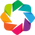

In [1]:
%matplotlib widget
%load_ext autoreload
%autoreload 2
import os
os.environ["GDAL_DATA"] = "/srv/conda/envs/notebook/share/gdal" # need to specify to make gdal work
os.environ["PROJ_LIB"] = "/srv/conda/envs/notebook/share/proj" # need to specify to make pyproj work
os.environ["PROJ_DATA"] = "/srv/conda/envs/notebook/share/proj" # need to specify to make pyproj work
import numpy as np
import pandas as pd
from matplotlib import cm 
import matplotlib
import matplotlib.pylab as plt
import matplotlib.gridspec as gridspec
import geopandas as gpd
from ipyleaflet import Map, basemaps, Polygon, Polyline, GeoData, LayersControl
from datetime import datetime
from dateutil.relativedelta import relativedelta
from rasterio import warp
import icepyx as ipx
import shutil

try:
    from ed.edcreds import getedcreds
except:
    print('No earthdata credentials found.')
    print('To set up, rename the folder "ed_example" to "ed".')
    print('Then, add your earthdata credentials to "ed/edcreds.py".')

from utils.nsidc import download_is2
from utils.readers import read_atl06
from utils.S2 import plotS2cloudfree, add_inset


## Show area of interest on a map

In [2]:
# I just drew these randomly on a map...
shape = 'data/shapefiles/gilac-grounding.geojson'
shape_buffer = 'data/shapefiles/kreitzer-region-large.geojson'

gdf = gpd.read_file(shape)
geom = [i for i in gdf.geometry]
lons,lats = geom[0].exterior.coords.xy
shape_coords = list(zip(lats,lons))
shape_bounds = [[np.min(lats),np.min(lons)], [np.max(lats),np.max(lons)]]

gdf = gpd.read_file(shape_buffer)
geom = [i for i in gdf.geometry]
lons,lats = geom[0].exterior.coords.xy
shape_buffer_coords = list(zip(lats,lons))

m=Map(basemap=basemaps.Esri.WorldImagery,center=[np.mean(lats),np.mean(lons)],zoom=7)
m.fit_bounds(shape_bounds)
polygon = Polygon(locations=shape_buffer_coords, color="red", fill_color="red", name='polygon_buffered')
m.add_layer(polygon)
polygon2 = Polygon(locations=shape_coords, color="blue", fill_color="blue", name='polygon')
m.add_layer(polygon2)
m.add_control(LayersControl())
m

Map(center=[-70.46223534840162, 72.12093417598801], controls=(ZoomControl(options=['position', 'zoom_in_text',…

## Download the ATL06 ICESat-2 Data

In [3]:
os.environ["EARTHDATA_USERNAME"] = getedcreds()[0]
os.environ["EARTHDATA_PASSWORD"] = getedcreds()[1]

short_name = 'ATL06'
spatial_extent = 'data/shapefiles/gilac-grounding.shp'
temporal = ['2018-01-01','2030-01-01']
region_a = ipx.Query(short_name, spatial_extent, temporal)
results = region_a.avail_granules(ids=True)
print('Found granules:')
results_print = np.array(results).flatten()
for i in range(np.min((len(results_print),10))):
    print(results_print[i])
if len(results_print)>10:
    print('...and %d more results.' % (len(results_print)-10))
region_a.avail_granules(ids=True)
output_dir = 'data/IS2/v006'

#### uncomment to download again
# region_a.download_granules(output_dir)

Found granules:
ATL06_20181016221240_02790110_006_02.h5
ATL06_20181017110023_02870112_006_02.h5
ATL06_20181114204857_07210110_006_02.h5
ATL06_20181115093639_07290112_006_02.h5
ATL06_20181213192444_11630110_006_02.h5
ATL06_20181214081227_11710112_006_02.h5
ATL06_20190111180049_02180210_006_02.h5
ATL06_20190112064832_02260212_006_02.h5
ATL06_20190115175225_02790210_006_02.h5
ATL06_20190213162841_07210210_006_02.h5
...and 147 more results.


### Get a list of all the ATL06 data files over this region

In [4]:
search_for = 'ATL06_'
search_in = output_dir + '/'
filelist = [search_in+f for f in os.listdir(search_in) \
            if os.path.isfile(os.path.join(search_in, f)) & (search_for in f) & ('.h5' in f)]
filelist.sort()
print('There are %i files.' % len(filelist))

There are 138 files.


## get a dataframe with basic file info (for all files / all tracks)

In [5]:
df_files = pd.DataFrame({'filename': filelist})
df_files['granule_id'] = df_files.apply(lambda x: x.filename[x.filename.find('ATL06_'):], axis=1)
df_files['date'] = df_files.apply(lambda x: x.granule_id[6:10]+'-'+x.granule_id[10:12]+'-'+x.granule_id[12:14], axis=1)
df_files['track'] = df_files.apply(lambda x: int(x.granule_id[21:25]), axis=1)

# figure out how many files there are per track 
files_per_track = df_files.groupby('track')[['filename']].count().rename(columns={'filename': 'number_of_files'})

# take only the tracks with at least min_files files 
min_files = 3
files_per_track = files_per_track[files_per_track.number_of_files >= min_files]

# show the results
files_per_track

,number_of_files
track,
218,17
226,18
279,20
721,20
729,21
1163,21
1171,20


## pick a single track / GTX combination, and work with only that from here on
Just pick a single combination to show some repeat tracks and develop code. If you are happy with your code and want to do this for more data in an automated way you can always put all your code into a loop that goes over all track/GTX combinations (if you have time for that). 

In [6]:
# can always go back to here and change this manually to a different track/GTX by changing the values below
# then re-run all the following cells
track = 721
gtx = 'gt3l'

# print to confirm the track/GTX selection
print('SELECTION: track %s, %s' % (track, gtx))

# Figure out which files there are for this track --> get a dataframe with file info for just the selected track
df_thistrack = df_files[df_files.track == track].copy()
# sort by date and re-set index 
df_thistrack = df_thistrack.sort_values(by='date').reset_index(drop=True)
# store the number of files for this track (this is the number of repeat passes / distinct dates from which we have data)
nfiles = len(df_thistrack)
print('  number of files available:', nfiles)

# initialize data dictionary for all the data for this track/GTX combination
gtx_data_dict = {}

# LOOP FOR ALL FILES
for i in range(nfiles):

    # get the filename
    this_filename = df_thistrack.iloc[i].filename
    print('  - %d: %s ' % (i, this_filename))

    # read in the data from this file using the function read_atl06()
    ancillary, dfs = read_atl06(this_filename)

    # make sure that there is data for the selected GTX in the file that we have read in
    if gtx in dfs.keys():

        # select the dataframe with the data for our GTX from the "dfs" dictionary
        this_data = dfs[gtx]

        # set data with questionable quality summary values to nan (i.e. nodata value)
        this_data[this_data.qual_summary != 0] = np.nan

        # set data with elevation values > 100 km to nan (because that's unreasonable)
        this_data[this_data.h > 1e5] = np.nan

        # now, just save the data for this gtx along with the ancillary data
        ancillary['data'] = this_data
        ancillary['gtx'] = gtx

        # save the data to the gtx_data_dict, with the key being the date of the data acquisition
        gtx_data_dict[ancillary['date']] = ancillary

        # print a success message
        print('    --> got %s data for %s' % (gtx, ancillary['date']))

    else:
        # if there is no data for the selected gtx on that date do nothing but print a message
        print('    --> NO %s data available for %s' % (gtx, ancillary['date']))

# figure out how many dates have data for the selected track / GTX combination and print
number_of_dates = len(gtx_data_dict)
print('\nFinished reading in data for track %s, %s. There is data for %d dates.' % (track, gtx, number_of_dates))

SELECTION: track 721, gt3l
  number of files available: 20
  - 0: data/IS2/v006/processed_ATL06_20181114204857_07210110_006_02.h5 
    --> got gt3l data for 2018-11-14
  - 1: data/IS2/v006/processed_ATL06_20190213162841_07210210_006_02.h5 
    --> got gt3l data for 2019-02-13
  - 2: data/IS2/v006/processed_ATL06_20190515120821_07210310_006_02.h5 
    --> got gt3l data for 2019-05-15
  - 3: data/IS2/v006/processed_ATL06_20191113032759_07210510_006_01.h5 
    --> got gt3l data for 2019-11-13
  - 4: data/IS2/v006/processed_ATL06_20200211230741_07210610_006_01.h5 
    --> got gt3l data for 2020-02-11
  - 5: data/IS2/v006/processed_ATL06_20200512184732_07210710_006_01.h5 
    --> got gt3l data for 2020-05-12
  - 6: data/IS2/v006/processed_ATL06_20200811142717_07210810_006_01.h5 
    --> NO gt3l data available for 2020-08-11
  - 7: data/IS2/v006/processed_ATL06_20201110100705_07210910_006_01.h5 
    --> got gt3l data for 2020-11-10
  - 8: data/IS2/v006/processed_ATL06_20210209054700_07211010

## make a function for basic plotting

In [7]:
def plot_repeat_track(gtx_data_dict, track, gtx):
    
    # make the figure for this track / GTX selection
    fig, ax = plt.subplots(figsize=[8,5])
    
    # loop through all dates
    for date in gtx_data_dict.keys():
    
        # get the data and ancillary for this date
        date_dict = gtx_data_dict[date]
    
        # get the strength of the beam (just an example of a property that you can access...)
        beamstrength = date_dict['gtx_strength_dict'][gtx]
    
        # get the elevation data for this date (we stored this in 'data' in the cell above)
        this_data = date_dict['data']
    
        # get the variables to plot (xatc and h)
        x_along_track = (this_data.xatc - this_data.xatc.min()) / 1000
        elevation = this_data.h
    
        # plot those variables
        ax.plot(x_along_track, elevation, label='%s, %s' % (date, beamstrength))
    
        # set the title and axis labels, set title to track/GTX selection that we made
        ax.set_title('track %s, %s' % (track, gtx))
        ax.set_xlabel('along-track distance (km)')
        ax.set_ylabel('elevation (m)')
    
        # make a legend
        ax.legend(loc='upper right', fontsize=7)

## call the function to plot elevation vs along-track distance for each date available

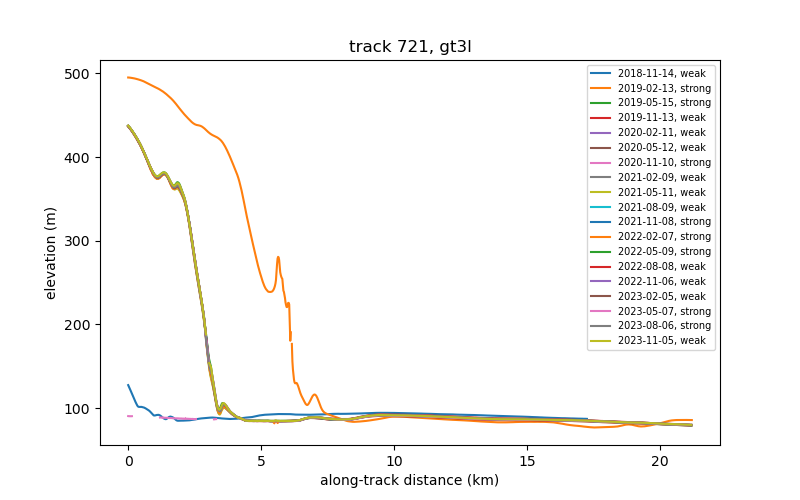

In [8]:
plot_repeat_track(gtx_data_dict, track, gtx)

## now that you have all the data you could make any desired changes, and then plot again!
for example, see what happens when you run this code and then plot in the cell below again

2018-11-14: across-track offset from median =  1627.11 m --> delete!
2019-02-13: across-track offset from median =  1338.62 m --> delete!
2019-05-15: across-track offset from median =     1.66 m --> keep!
2019-11-13: across-track offset from median =     0.11 m --> keep!
2020-02-11: across-track offset from median =     0.94 m --> keep!
2020-05-12: across-track offset from median =      nan m --> delete!
2020-11-10: across-track offset from median =     5.20 m --> keep!
2021-02-09: across-track offset from median =      nan m --> delete!
2021-05-11: across-track offset from median =    22.30 m --> delete!
2021-08-09: across-track offset from median =     2.56 m --> keep!
2021-11-08: across-track offset from median =     2.70 m --> keep!
2022-02-07: across-track offset from median =     4.55 m --> keep!
2022-05-09: across-track offset from median =     9.84 m --> keep!
2022-08-08: across-track offset from median =     0.53 m --> keep!
2022-11-06: across-track offset from median =     4.

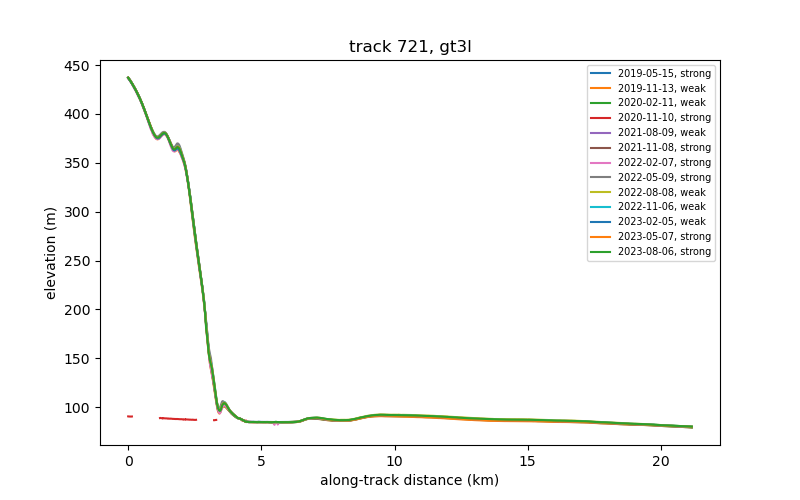

In [10]:
# make a copy of the data dictionary (to keep the old one so you don't have to re-run the cells above this)
new_gtx_data_dict = gtx_data_dict.copy()

# get mean across track distances from the data (initialize empty list, then fill with values for all dates)
mean_across_track_distances = []
for date in new_gtx_data_dict.keys():
    mean_across_track = np.nanmean(new_gtx_data_dict[date]['data'].yatc)
    new_gtx_data_dict[date]['mean_across_track'] = mean_across_track
    mean_across_track_distances.append(mean_across_track)

# get the median across-track distance for all repeat passes 
across_track_median = np.nanmedian(mean_across_track_distances)

# now delete the data that is further away from the median than max_difference_across_track meters
max_difference_across_track = 10 # meters
for date in list(new_gtx_data_dict.keys()):

    # if mean across-track distance from this date is less than max_difference_across_track meters away from the median for all dates
    across_track_offset = np.abs(new_gtx_data_dict[date]['mean_across_track'] - across_track_median)
    keep = np.abs(across_track_offset) <= max_difference_across_track
    action = 'keep' if keep else 'delete'
    print('%s: across-track offset from median = %8.2f m --> %s!' % (date, across_track_offset, action))
    
    if not keep:
        # delete the entry for this date
        del new_gtx_data_dict[date]

# call the plotting function again
plot_repeat_track(new_gtx_data_dict, track, gtx)